# Character Level Language Model

In [1]:
from collections import Counter
import numpy as np
import torch
from rich import print
from rich import pretty
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
pretty.install()

## Bigram

### Read in the data

In [4]:
with open('../data/names.txt') as f:
    words = list(map(lambda x: x.strip(), f.readlines()))

In [5]:
words[:10]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']

In [6]:
len(words)

32033

### Minimum Length

In [7]:
min(len(w) for w in words)

2

### Maximum Length

In [8]:
max(len(w) for w in words)

15

### Create paring of n<sup>th</sup> and n + 1<sup>th</sup> position characters

In [9]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m

m m

m a

#### Add start (\<S>) and end(\<E>) tokens to the word
> The model will know the starting and ending of the word

In [10]:
def generate_pairings(words, start_token='<S>', end_token='<E>'):
    for w in words:
        chs = [start_token] + list(w) + [end_token]
        for ch1, ch2 in zip(chs, chs[1:]):
            yield ch1, ch2

In [11]:
for ch1, ch2 in generate_pairings(words[:1]):
    print(ch1, ch2)

<S> e

e m

m m

m a

a <E>

#### lets see for 3 words

In [12]:
for ch1, ch2 in generate_pairings(words[:3]):
    print(ch1, ch2)

<S> e

e m

m m

m a

a <E>

<S> o

o l

l i

i v

v i

i a

a <E>

<S> a

a v

v a

a <E>

### Count of bigrams

#### Bigram for 3 words

In [13]:
def create_bigram_counter(words):
    b = Counter()
    for ch1, ch2 in generate_pairings(words):
        bigram = (ch1, ch2)
        b[bigram] += 1
    return b

In [14]:
create_bigram_counter(words[:3])

Counter({
    ('<S>', 'e'): 1,
    ('e', 'm'): 1,
    ('m', 'm'): 1,
    ('m', 'a'): 1,
    ('a', '<E>'): 3,
    ('<S>', 'o'): 1,
    ('o', 'l'): 1,
    ('l', 'i'): 1,
    ('i', 'v'): 1,
    ('v', 'i'): 1,
    ('i', 'a'): 1,
    ('<S>', 'a'): 1,
    ('a', 'v'): 1,
    ('v', 'a'): 1
})

#### Bigram for all words

In [15]:
b = create_bigram_counter(words)

In [16]:
b.most_common(10)

[
    (('n', '<E>'), 6763),
    (('a', '<E>'), 6640),
    (('a', 'n'), 5438),
    (('<S>', 'a'), 4410),
    (('e', '<E>'), 3983),
    (('a', 'r'), 3264),
    (('e', 'l'), 3248),
    (('r', 'i'), 3033),
    (('n', 'a'), 2977),
    (('<S>', 'k'), 2963)
]

### Create 2D array of the bigram


#### Little warmup with `tensors`

In [17]:
a = torch.zeros((3, 5), dtype=torch.int32)
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [18]:
a.dtype

torch.int32

In [19]:
a[1,3] = 1
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [20]:
a[1, 3] += 1
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

#### 2D matrix of alpahabets

In [21]:
def get_stoi(words, start_token, end_token, tokens_at_start=True):
    chars = []
    if tokens_at_start:
        chars.append(start_token)
        if start_token != end_token: chars.append(end_token)
        
    chars.extend(sorted(list(set(''.join(words)))))

    if not tokens_at_start:
        chars.append(start_token)
        if start_token != end_token: chars.append(end_token)

    stoi = {s:i for i,s in enumerate(chars)}
    
    return stoi

In [22]:
stoi = get_stoi(words, '<S>', '<E>', tokens_at_start=False)
stoi

{
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'j': 9,
    'k': 10,
    'l': 11,
    'm': 12,
    'n': 13,
    'o': 14,
    'p': 15,
    'q': 16,
    'r': 17,
    's': 18,
    't': 19,
    'u': 20,
    'v': 21,
    'w': 22,
    'x': 23,
    'y': 24,
    'z': 25,
    '<S>': 26,
    '<E>': 27
}

In [23]:
def create_bigram_matrix(words, start_token, end_token, tokens_at_start=True):
    stoi = get_stoi(words, start_token, end_token, tokens_at_start)
    alphabet_size = len(stoi)
    N = torch.zeros((alphabet_size, alphabet_size), dtype=torch.int32)
    for ch1, ch2 in generate_pairings(words, start_token, end_token):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
    return N

In [24]:
N = create_bigram_matrix(words, '<S>', '<E>', False)

In [25]:
N[:10, :10]

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55],
        [ 242,    0,    0,    0,  123,   44,    1,    1,  160,    0],
        [ 330,    3,    0,   19,  334,    1,   25,  360,  190,    3],
        [2244,    8,    2,   24,  674,    2,    2,    1,  729,    9],
        [2445,  110,  509,  440, 1653,  101,  428,   95,   82,   76],
        [1473,    1,    4,    4,  440,    0,    0,   45,  119,    2]],
       dtype=torch.int32)

The type of a cell in the above `N` is tensor

In [26]:
type(N[1, 1])

<class 'torch.Tensor'>

Therefore we have to call it with `.item()` to get the value

In [27]:
type(N[1, 1].item())

<class 'int'>

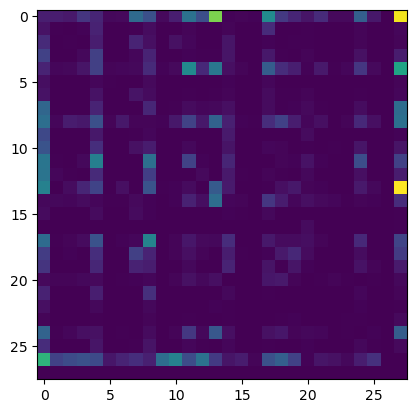

In [28]:
plt.imshow(N)

In [29]:
itos = dict(map(reversed, stoi.items()))
itos

{
    0: 'a',
    1: 'b',
    2: 'c',
    3: 'd',
    4: 'e',
    5: 'f',
    6: 'g',
    7: 'h',
    8: 'i',
    9: 'j',
    10: 'k',
    11: 'l',
    12: 'm',
    13: 'n',
    14: 'o',
    15: 'p',
    16: 'q',
    17: 'r',
    18: 's',
    19: 't',
    20: 'u',
    21: 'v',
    22: 'w',
    23: 'x',
    24: 'y',
    25: 'z',
    26: '<S>',
    27: '<E>'
}

In [30]:
def plot_matrix(N):
    plt.figure(figsize=(16, 16))
    plt.imshow(N, cmap='Blues')
    for i in range(N.shape[0]):
        for j in range(N.shape[1]):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
    plt.axis("off")

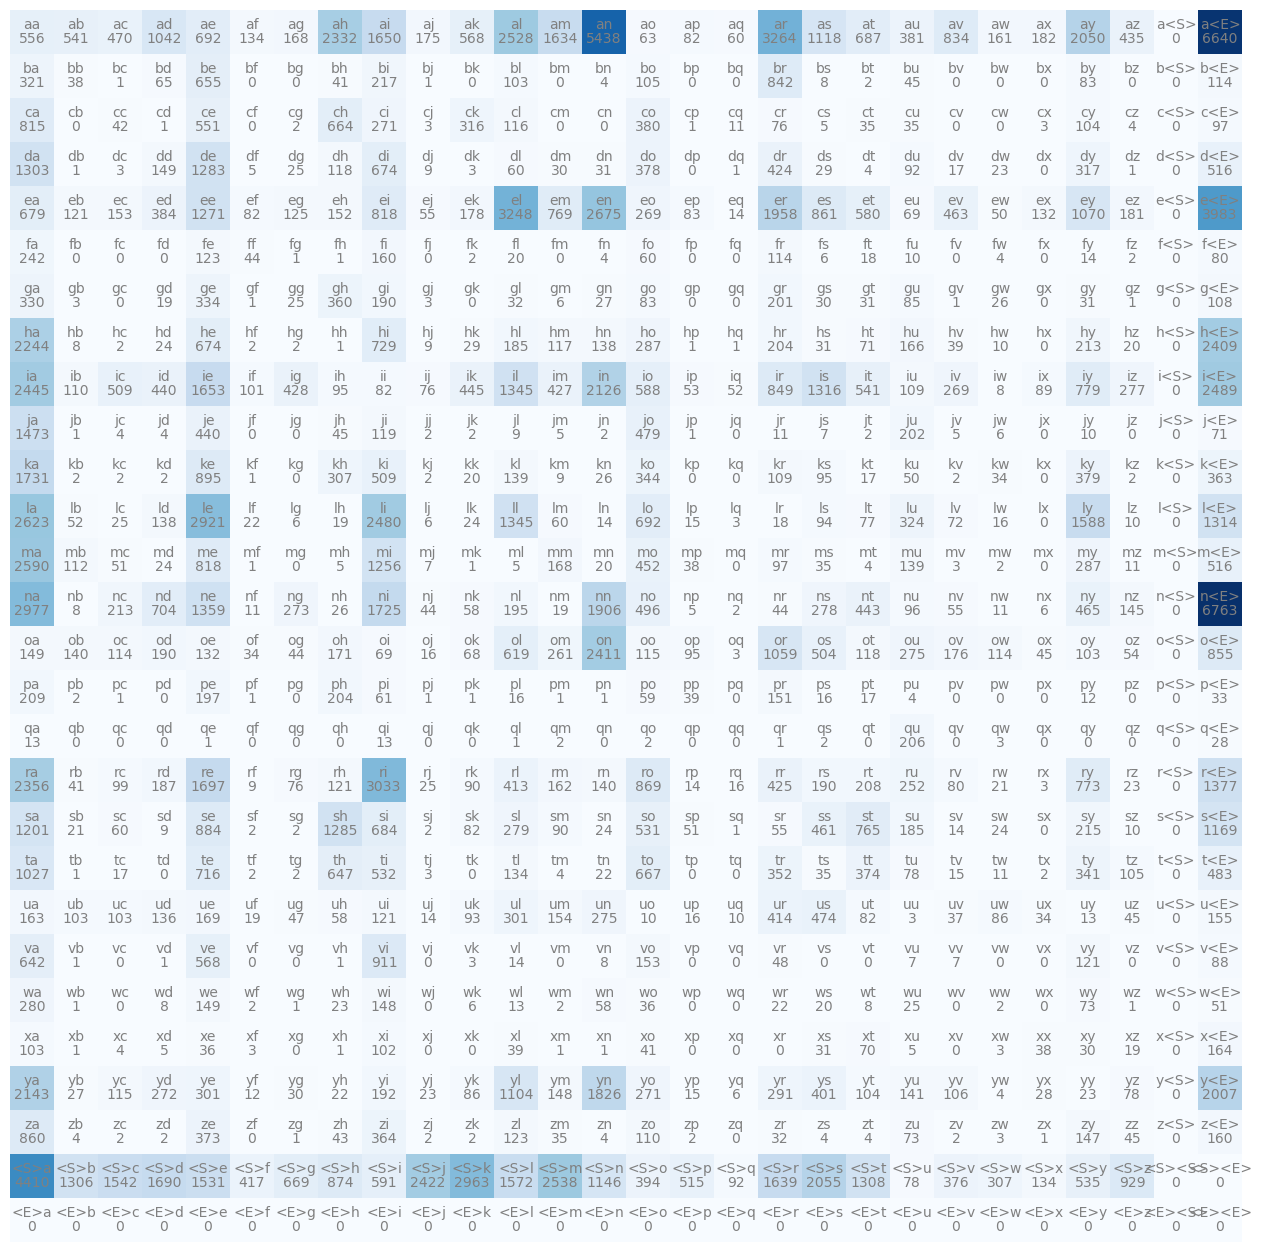

In [31]:
plot_matrix(N)

#### Remove `<E>` and `<S>` in favor of a single `.` token
> Will deduct the columns and row having 0 values

In [32]:
get_stoi(words, '.', '.')

{
    '.': 0,
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'e': 5,
    'f': 6,
    'g': 7,
    'h': 8,
    'i': 9,
    'j': 10,
    'k': 11,
    'l': 12,
    'm': 13,
    'n': 14,
    'o': 15,
    'p': 16,
    'q': 17,
    'r': 18,
    's': 19,
    't': 20,
    'u': 21,
    'v': 22,
    'w': 23,
    'x': 24,
    'y': 25,
    'z': 26
}

In [33]:
N = create_bigram_matrix(words, '.', '.')

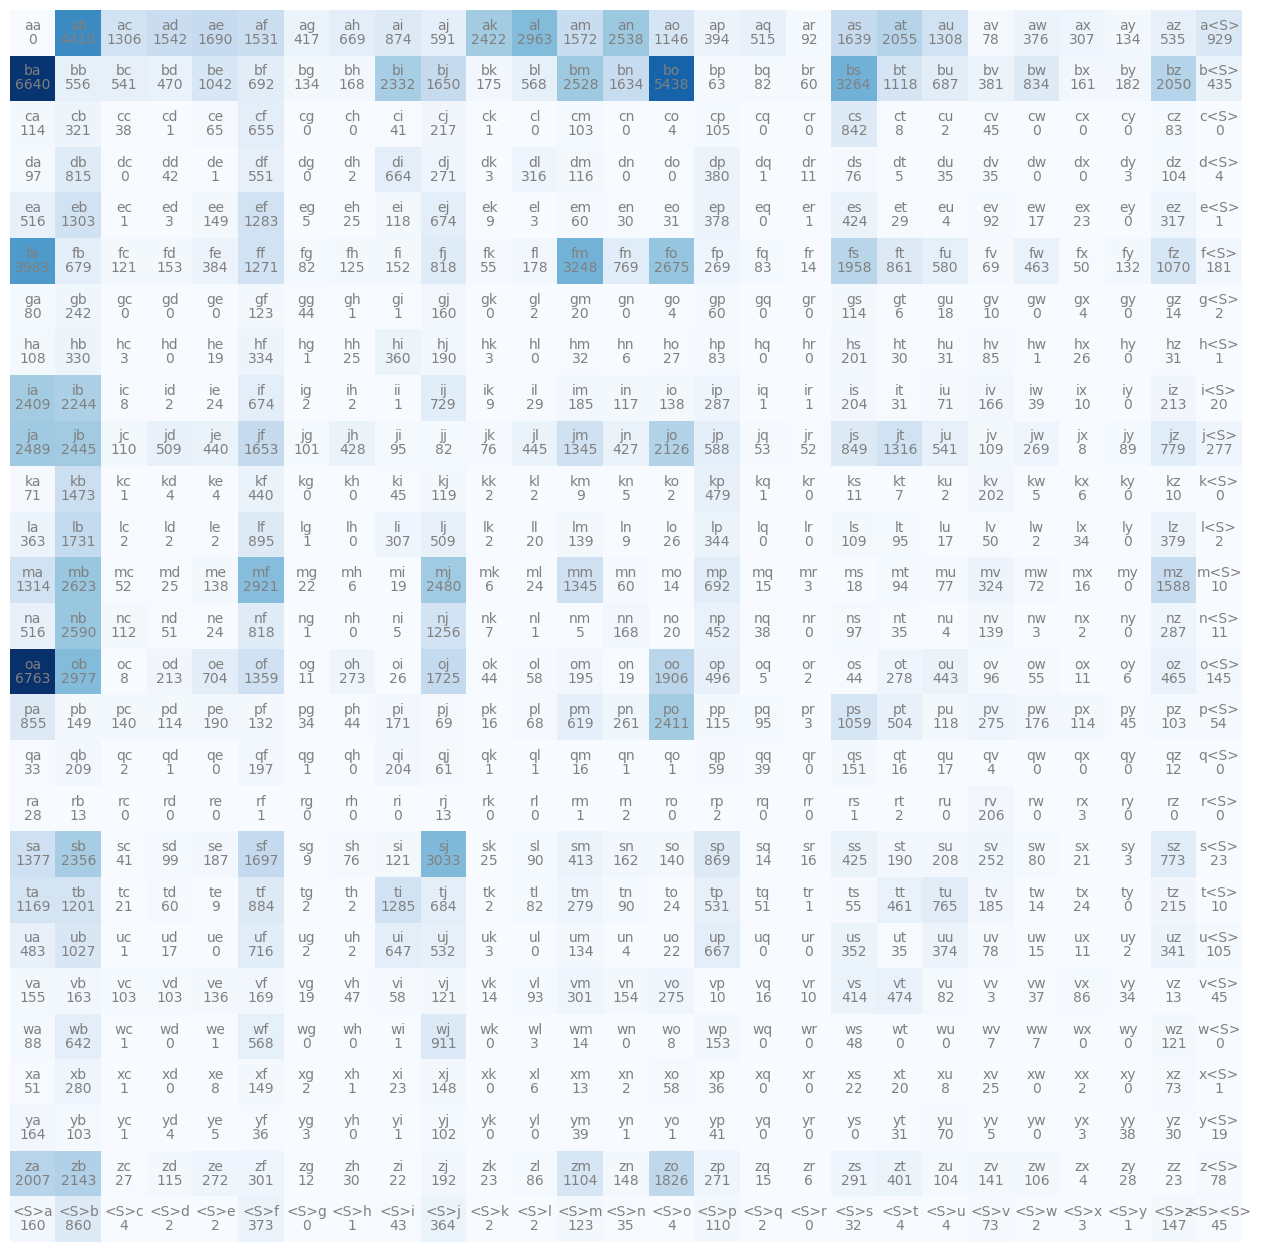

In [34]:
plot_matrix(N)

In [35]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

### Sampling

#### Warm up with probability tensor

In [36]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p

tensor([0.7081, 0.3542, 0.1054])

In [37]:
p.sum()

tensor(1.1678)

In [38]:
p = p/p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

##### Drawing 20 samples

In [39]:
p_dist = torch.multinomial(p, num_samples=20, replacement=True, generator=g)
p_dist

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [40]:
len(p_dist[p_dist == 0])/len(p_dist)

0.45

In [41]:
len(p_dist[p_dist == 1])/len(p_dist)

0.45

In [42]:
len(p_dist[p_dist == 2])/len(p_dist)

0.1

##### Drawing 50 samples

In [43]:
p_dist = torch.multinomial(p, num_samples=50, replacement=True, generator=g)
p_dist

tensor([0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0])

In [44]:
len(p_dist[p_dist == 0])/len(p_dist)

0.64

In [45]:
len(p_dist[p_dist == 1])/len(p_dist)

0.32

In [46]:
len(p_dist[p_dist == 2])/len(p_dist)

0.04

#### Drawing a character wrt to probability of occurance

In [47]:
p = N[0].float()
p = p / p.sum() 
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [48]:
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix

19

In [49]:
itos[ix]

't'

In [54]:
g = torch.Generator().manual_seed(2147483647)

p_occurance = lambda ix: N[ix].float()/N[ix].sum()

def generate_names(count, pdist_func):
    for i in range(count):
        out = []
        ix = 0
        while True:
            p = pdist_func(ix)
            ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
            out.append(itos[ix])
            if ix == 0:
                break
        print(''.join(out))

In [55]:
generate_names(10, p_occurance)

npsa

byya

njobznpszmfta

lpoembjtbia

boditij<S>bsjfa

pebsfoa

jbeebtia

ia

kijobujfoa

fhvtima

#### Drawing a character wrt to uniform probability 

In [56]:
p_uniform = lambda ix: torch.ones(len(N[ix]))/len(N[ix])

In [57]:
generate_names(10, p_uniform)

jedya

dfln<S>vdkokpfpwkwshhrsksa

dgcibcltmqplda

yuyxcqnlovvtyeh<S>gfyixrqmeqeox<S>wlzytrkgpsrrqgytuxlgpvgiwxgintvzzpuwdwwrqgdczekdpvilbklirooqrnnmmbpserza

ht<S>qxa

<S>mhjkjoboh<S><S>vvmtzwrsvgvbxbwtecoxwmnszqwhstghqtihonxbgrntkewciohwpjjhyilxemuselxobh<S>zlorwa

mgtuerjhwodepjefutvlheqa

dgqktyfrkdtnkxhv<S>fta

xpgmgkygmzmhcfhqkeqpweuxa

em<S>ztrusciyideofjvvna

### Vectorized normalization of rows and columns

#### Warm up with normalization

In [58]:
P = N.float()

In [59]:
P.shape

torch.Size([27, 27])

In [61]:
P.sum(0, keepdim=True).shape

torch.Size([1, 27])

In [62]:
P.sum(1, keepdim=True).shape

torch.Size([27, 1])

In [63]:
P.sum(0, keepdim=False).shape

torch.Size([27])

In [64]:
P.sum(1, keepdim=False).shape

torch.Size([27])